## Exporting yolo v8 models to Pytorch Mobile

If possible, it should work with [this (kind of) official demo](https://github.com/pytorch/ios-demo-app/tree/master/ObjectDetection)


### YOLOv8

In [1]:
DETECTOR_DIR = "third_party/ultralytics/"
!git -C {DETECTOR_DIR} pull || git clone https://github.com/ultralytics/ultralytics {DETECTOR_DIR}

Already up to date.


#### Export model using `ultralytics` script

In [6]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append("third_party/ultralytics")
from ultralytics import YOLO

model_name = "yolov8s"

# Load a model
model = YOLO("yolov8s.pt")  # load an official model

# Export the model
model.export(format="torchscript", optimize=True)

# run using the ultralytics library
# Load a model
model = YOLO("yolov8s.torchscript", task="detect")  # pretrained YOLOv8n model
# print("model stride:", model.stride)
# Run batched inference on a list of images
results = model(["third_party/ultralytics/ultralytics/assets/zidane.jpg"])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


AttributeError: 'YOLO' object has no attribute 'stride'

In [16]:
def draw_detections(img, box, score, class_id):
    # img = cv2.transpose(img)
    x1, y1, w, h = box

    # Retrieve the color for the class ID
    color = (255,0,0)

    # Draw the bounding box on the image
    cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

    # Create the label text with class name and score
    label = f"{metadata["names"][str(class_id.item())]}: {score:.2f}"

    # Calculate the dimensions of the label text
    (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

    # Calculate the position of the label text
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

    # Draw a filled rectangle as the background for the label text
    cv2.rectangle(
        img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
    )

    # Draw the label text on the image
    cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)


Loading yolov8s.torchscript for TorchScript inference...
{'description': 'Ultralytics YOLOv8s model trained on coco.yaml', 'author': 'Ultralytics', 'date': '2024-07-06T14:11:00.967676', 'version': '8.2.50', 'license': 'AGPL-3.0 License (https://ultralytics.com/license)', 'docs': 'https://docs.ultralytics.com', 'stride': 32, 'task': 'detect', 'batch': 1, 'imgsz': [640, 640], 'names': {'0': 'person', '1': 'bicycle', '2': 'car', '3': 'motorcycle', '4': 'airplane', '5': 'bus', '6': 'train', '7': 'truck', '8': 'boat', '9': 'traffic light', '10': 'fire hydrant', '11': 'stop sign', '12': 'parking meter', '13': 'bench', '14': 'bird', '15': 'cat', '16': 'dog', '17': 'horse', '18': 'sheep', '19': 'cow', '20': 'elephant', '21': 'bear', '22': 'zebra', '23': 'giraffe', '24': 'backpack', '25': 'umbrella', '26': 'handbag', '27': 'tie', '28': 'suitcase', '29': 'frisbee', '30': 'skis', '31': 'snowboard', '32': 'sports ball', '33': 'kite', '34': 'baseball bat', '35': 'baseball glove', '36': 'skateboard'

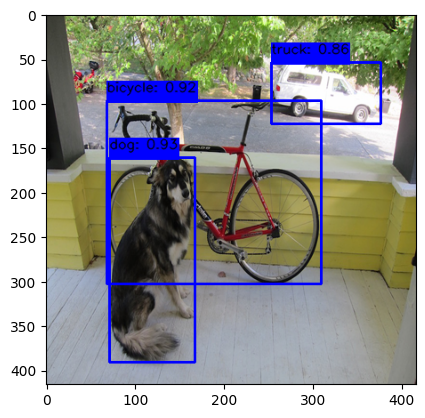

In [42]:
# load model
import cv2, torch, json, numpy as np
from matplotlib import pyplot as plt
from ultralytics.data.augment import LetterBox

w=f"{model_name}.torchscript"

device = "cpu"
print(f"Loading {w} for TorchScript inference...")
extra_files = {"config.txt": ""}  # model metadata
model = torch.jit.load(w, _extra_files=extra_files, map_location=device)
# print("model stride", model.stride)
fp16 = False
# model.half() if fp16 else model.float()
if extra_files["config.txt"]:  # load metadata dict
    metadata = json.loads(extra_files["config.txt"], object_hook=lambda x: dict(x.items()))
print(metadata)

# im = cv2.imread("test1.png")
im = cv2.imread("third_party/ultralytics/ultralytics/assets/test1.png")
original_image = im.copy()

# same_shapes = len({x.shape for x in im}) == 1
letterbox = LetterBox(640)
im = letterbox(image=im)

print("im", im.shape)
plt.imshow(im[:,:,::-1])
# raise

# im = im[:,:, ::-1].transpose((0, 3, 1, 2))
# im = np.ascontiguousarray(im)  # contiguous

# taken from preprocess in predict file
im = np.stack([im])
im = im[..., ::-1].transpose((0, 3, 1, 2))  # BGR to RGB, BHWC to BCHW, (n, 3, h, w)
im = np.ascontiguousarray(im)  # contiguous
im = torch.from_numpy(im)

im = im.to("cpu")
im = im.float()  # uint8 to fp16/32
im /= 255  # 0 - 255 to 0.0 - 1.0
print("im.shape", im.shape)
print(im[0,0,:,0])
# raise

# im = torch.from_numpy(im)
# im = im.to("cpu")
# im = im.float() / 255.0
print("im", im)
# im = torch.from_numpy(im).to(device).float()
# im = torch.unsqueeze(im, 0)
# im = im.permute(0, 3, 2, 1) 

outputs = model.forward(im)
outputs = np.transpose(np.squeeze(outputs[0]))
print("outputs", outputs)

rows = outputs.shape[0]

# Lists to store the bounding boxes, scores, and class IDs of the detections
boxes, scores, class_ids = [], [], []

# Calculate the scaling factors for the bounding box coordinates
x_factor = original_image.shape[1] / 640
y_factor = original_image.shape[0] / 640

conf_threshold = 0.5

# Iterate over each row in the outputs array
for i in range(rows):
    # Extract the class scores from the current row
    classes_scores = outputs[i][4:]

    # Find the maximum score among the class scores
    max_score = np.amax(np.array(classes_scores))
    print(max_score, end=" ")

    # If the maximum score is above the confidence threshold
    if max_score >= conf_threshold:
        # Get the class ID with the highest score
        class_id = np.argmax(classes_scores)

        # Extract the bounding box coordinates from the current row
        x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

        # Calculate the scaled coordinates of the bounding box
        left = int((x - w / 2) * x_factor)
        top = int((y - h / 2) * y_factor)
        width = int(w * x_factor)
        height = int(h * y_factor)

        # Add the class ID, score, and box coordinates to the respective lists
        class_ids.append(class_id)
        scores.append(max_score)
        boxes.append([left, top, width, height])

print()
print("boxes", len(boxes))

indices = cv2.dnn.NMSBoxes(boxes, scores, conf_threshold, 0.5)
print("remained boxes", len(indices))


# Apply non-maximum suppression to filter out overlapping bounding bo
# Iterate over the selected indices after non-maximum suppression
for i in indices:
    # Get the box, score, and class ID corresponding to the index
    box = boxes[i]
    score = scores[i]
    class_id = class_ids[i]
    print(box)
    print("score", score, "class_id", metadata["names"][str(class_id.item())])

    # Draw the detection on the input image
    draw_detections(original_image, box, score, class_id)

plt.imshow(original_image[:,:,::-1])



In [37]:
print(im.shape)


torch.Size([1, 3, 640, 640])


### Setup the demo app

#### Clone if doesn't exists

In [6]:
DEMO_DIR = "third_party/pytorch-ios-demo-app"
!git -C {TARGET_DIR} pull || git clone https://github.com/pytorch/ios-demo-app {DEMO_DIR}

fatal: cannot change to '{TARGET_DIR}': No such file or directory
fatal: destination path '{DEMO_DIR}' already exists and is not an empty directory.


#### Install pods 
(IMPORTANT!) The version of the Lib-Torch specified in the Podfile will not work in the current version of the model/exporter. So we need to patch it.

In [7]:

import os

with open(f"{DEMO_DIR}/ObjectDetection/Podfile", "r") as f, \
        open(f"{DEMO_DIR}/ObjectDetection/Podfile_fixed_for_yolov8", "w") as f_out:
    content = f.readlines()
    for ln in content:
        if "LibTorch-Lite" in ln:
            ln = "  pod 'LibTorch-Lite', '~>1.2'\n"
        f_out.write(ln)

os.rename(f'{DEMO_DIR}/ObjectDetection/Podfile_fixed_for_yolov8', f'{DEMO_DIR}/ObjectDetection/Podfile')
print("Podfile updated")

Podfile updated


In [8]:
!cd {DEMO_DIR}/ObjectDetection && pod install

Analyzing dependencies
Installing LibTorch-Lite 1.13.0.1 (was 2.1.0)
Generating Pods project
Integrating client project
Pod installation complete! There is 1 dependency from the Podfile and 1 total pod installed.

[!] Automatically assigning platform `iOS` with version `14.0` on target `ObjectDetection` because no platform was specified. Please specify a platform for this target in your Podfile. See `https://guides.cocoapods.org/syntax/podfile.html#platform`.


🚨 Copy the `yolo5n.torchscript` to the xcode project, modify the `Inference/ObjectDetector.swift` to reference this new file by changing the `let filePath` line to `if let filePath = Bundle.main.path(forResource: "yolov5n", ofType: "torchscript"),`. It should work 🤞
